# Notebook de modélisation
### Sommaire : 
- [1 - Import packages](#1)
- [2 - Import data](#2)
- [3 - Feature engineering](#3)
    - [3.1 - Features continues](#3.1)
    - [3.2 - Features catégorielles](#3.2)
    - [3.3 - Features spécifiques (temporelles)](#3.3)
    - [3.4 - Pipeline globale](#3.4)
    - [3.5 - Test de la pipeline globale](#3.5)
- [4 - Modelisation](#4)
    - [4.1 - Sélection du modèle/recherche d'hyperparamètres](#4.1)
    - [4.2 Vérification résultats sur le dataset de test](#4.2)
- [5 - Sauvegarde](#5)
- [6 - Explicabilité](#6)

# 1 - Import packages <a name="1"></a>

In [195]:
import pandas as pd
import math
import missingno as msno
pd.options.display.max_columns = 100
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
import pickle
import shap
import warnings
warnings.filterwarnings('ignore')

In [68]:
from utils import weighted_log_loss

# 2 - Import data<a name="2"></a>

In [4]:
train = pd.read_csv('data/train.csv', dtype={'location':object,'target':object})
test = pd.read_csv('data/test.csv', dtype={'location':object})
print(f"Shape of train dataset: {train.shape}")
print(f"Shape of test dataset : {test.shape}")

Shape of train dataset: (25000, 24)
Shape of test dataset : (25000, 23)


In [5]:
dept = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/70cef74f-70b1-495a-8500-c089229c0254', usecols=['code_departement', 'nom_region'])

In [6]:
train = train.merge(dept, how='left', left_on="location", right_on="code_departement")
test = test.merge(dept, how='left', left_on="location", right_on="code_departement")

In [7]:
# cleaning - drop columns with 50% or more of nan
perc = 50
min_count =  int(((100-perc)/100)*train.shape[0] + 1)
train = train.dropna(axis=1, thresh=min_count)
test = test[[col for col in train.columns if col != 'target']]

In [8]:
train.shape, test.shape

((25000, 22), (25000, 21))

In [151]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(train[[col for col in train.columns if col != 'target']], 
                                                    train['target'], test_size=0.2)

In [153]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20000, 21), (20000,), (5000, 21), (5000,))

# 3. Feature engineering<a name="3"></a>

Le feature engineering va se faire avec les pipelines. Cela simplifie le code et améliore sa lisibilité. On peut aussi facilement tester plusieurs approches différentes dans notre recherche d'hyperparamètres

In [9]:
train.head()

,id,AP,creation_date_answer,situation,location,gc_id,gc_label,creation_date_global,id_group,id_group_2,favorite_fruit,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,green_vegetables,target,code_departement,nom_region
0,a46cfa61ea20a,f,2019-03-13 11:14:42.549,-1,52,70,G,2019-01-17 10:50:57.767,2d7e206d46ea1,36bac09400660,poire,120,jzy,-1,812a43d710ace,2019-03-13 11:14:42.549,football,aa8f4934a31eb,f,0,52,Grand Est
1,c3d0cb8f0c5e2,f,2019-03-21 14:27:32.441,-1,78,10,A,2018-08-20 05:57:51.038,35e96d6848871,80a697d593706,clementine,10,ae,-1,4b59257f24573,2019-03-21 14:27:32.441,football,6ff9ea9ec85fd,f,1,78,Île-de-France
2,05dfbe0ec3a8b,f,2019-03-15 17:49:50.67,-1,70,10,A,2018-12-20 13:45:51.752,ffaf8085e383d,c309176b96268,clementine,200,ag,-1,f1a838f0d194b,2019-03-15 17:49:50.67,football,6a49a0a97b049,f,0,70,Bourgogne-Franche-Comté
3,952e869ee1076,f,2019-01-07 08:19:29.114,-1,84,10,A,2018-07-21 10:28:49.386,5360cf0a40ce3,13c1a3597648b,clementine,10,ae,0,c3196847d1c14,2019-01-07 08:19:29.114,football,d0dcf1ca1bf04,f,1,84,Provence-Alpes-Côte d'Azur
4,5bd0e71b1395b,f,2019-02-03 17:57:22.926,-1,29,20,D,2018-12-07 19:59:26.968,126c3211f23fc,7b68e0a456571,clementine,10,ae,-1,70e18c6fe58cd,2019-02-03 17:57:22.926,football,b4870b1c8eb42,f,1,29,Bretagne


In [131]:
# Variables choisies
numerical_features = ["situation", "gc_id", "fruit_situation_id", "number_of_fruit"]
categorical_features = ["AP", "gc_label", "favorite_fruit", "fruit_situation_label", "hobby", "green_vegetables", "nom_region"]
date_features = ["creation_date_global"]
target = ["target"]

In [132]:
# Permet de sélectionner les variables concernées par la pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names   
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        return X.loc[:, self.feature_names].copy(deep=True)

## 3.1 Features continues<a name="3.1"></a>

In [23]:
# Pipeline pour les features continues : sélection des features + imputation des valeurs manquantes + standard scaling
numerical_pipeline = Pipeline(steps = [ 
    ("num_selector", FeatureSelector(numerical_features)),
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler()) 
])

## 3.2 Features catégorielles<a name="3.2"></a>

In [24]:
# Pipeline pour les features catégorielles : sélection des features + one hot encoding
categorical_pipeline = Pipeline(steps = [ 
    ("num_selector", FeatureSelector(categorical_features)),
    ("ohe", OneHotEncoder(
        handle_unknown="ignore", 
        sparse=False,
        categories='auto')
    ) 
])

## 3.3 Features spécifiques (temporelles)<a name="3.3"></a>

In [47]:
# Pipeline spécifique aux features temporelles
class date_processing_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        for col in date_features:
            X.loc[:, col] = pd.to_datetime(X.loc[:, col])
            X.loc[:, col+"_month"] = X.loc[:, col].dt.month
            X.loc[:, col+"_weekday"] = X.loc[:, col].dt.weekday
            X.loc[:, col+"_month_norm"] = 2 * math.pi * X.loc[:, col+"_month"] / X.loc[:, col+"_month"].max()
            X.loc[:, col+"_month_cos"] = np.cos(X.loc[:, col+"_month_norm"])
            X.loc[:, col+"_weekday_norm"] = 2 * math.pi * X.loc[:, col+"_weekday"] / X.loc[:, col+"_weekday"].max()
            X.loc[:, col+"_weekday_cos"] = np.cos(X.loc[:, col+"_weekday_norm"])
        liste_cols = [[col+"_weekday_cos", col+"_month_cos"] for col in date_features]
        flat_list = [item for sublist in liste_cols for item in sublist]
        return X.loc[:, flat_list]


date_processing_features_pipeline = Pipeline(steps = [ 
    ("selector", FeatureSelector(date_features)),
    ("feature_engineering", date_processing_features()),
    ("imputer", SimpleImputer(strategy="median"))
])

In [48]:
liste_cols = [[col+"_weekday_cos", col+"_month_cos"] for col in date_features]
flat_list_date_features = [item for sublist in liste_cols for item in sublist]

## 3.4 Pipeline globale<a name="3.4"></a>

In [56]:
# Union des pipelines du feature engineering
feature_pipeline = FeatureUnion(
    n_jobs=-1, 
    transformer_list=[ 
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
        ("date_features_pipeline", date_processing_features_pipeline),
    ]
)

## 3.5 Test de la pipeline globale<a name="3.5"></a>

In [142]:
def test_feature_pipeline():
    test_df = train.sample(5).copy(deep=True).reset_index()
    display(test_df)
    feature_pipeline.fit(test_df)
    test_results = pd.DataFrame(feature_pipeline.transform(test_df),
            columns = (
                numerical_features 
                + list(feature_pipeline.transformer_list[1][1]["ohe"].get_feature_names(categorical_features))
                + list(flat_list_date_features)
            ))
    display(test_results)
    return test_results
test_results = test_feature_pipeline()

,index,id,AP,creation_date_answer,situation,location,gc_id,gc_label,creation_date_global,id_group,id_group_2,favorite_fruit,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,green_vegetables,target,code_departement,nom_region
0,18419,684355024dd59,f,2019-01-11 11:08:13.674,-1,32,20,D,2018-12-28 09:52:41.621,fedf42bd1823f,51544d0e8775c,clementine,10,ae,-1,c7aae3098de10,2019-01-11 11:08:13.674,football,9a5c503111a95,f,1,32,Occitanie
1,21258,b70726071d817,f,2019-01-07 06:50:00,-1,31,20,D,2019-01-07 11:31:05.285,82b4ea15ff5aa,649f37ae10034,clementine,80,li,-1,06765cf62d184,2019-01-07 06:50:00,football,77f223998407e,f,0,31,Occitanie
2,4152,00190978bb020,f,2019-01-29 08:28:50.866,-1,46,40,B,2018-04-26 14:00:19.739,0c945f92c5aaf,37a206ebd3be2,poire,10,ae,-1,ab5f56971243b,2019-01-29 08:28:50.866,football,0b86cd9365cbd,f,1,46,Occitanie
3,11419,89e6f78d7738d,f,2019-01-07 10:08:45.637,-1,56,20,D,2017-08-11 00:00:00.000,d2b739561c0ae,9faf97a9255b7,clementine,120,jzy,-1,cdcb1bbdab594,2019-01-07 10:08:45.637,football,71fa6e1f7b590,f,0,56,Bretagne
4,13202,efddd0449f17a,f,2019-02-20 11:52:00,-1,89,20,D,2019-02-11 15:51:21.233,ba24ce7c199b6,f5e555b6ff7b1,clementine,120,jzy,-1,05507335b6296,2019-02-20 11:52:00,football,2eeae2376c26c,f,0,89,Bourgogne-Franche-Comté


,situation,gc_id,fruit_situation_id,number_of_fruit,AP_f,gc_label_B,gc_label_D,favorite_fruit_clementine,favorite_fruit_poire,fruit_situation_label_ae,fruit_situation_label_jzy,fruit_situation_label_li,hobby_football,green_vegetables_f,nom_region_Bourgogne-Franche-Comté,nom_region_Bretagne,nom_region_Occitanie,creation_date_global_weekday_cos,creation_date_global_month_cos
0,0.0,-0.5,-1.170345,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.000000e+00,1.000000
1,0.0,-0.5,0.242140,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.000000e+00,0.866025
2,0.0,2.0,-1.170345,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.836970e-16,-0.500000
3,0.0,-0.5,1.049275,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.000000e+00,-0.500000
4,0.0,-0.5,1.049275,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.000000e+00,0.500000


#### == Analyse == 
La pipeline feature engineering fonctionne bien

# 4. Modelisation<a name="4"></a>

## 4.1 Sélection du modèle/recherche d'hyperparamètres<a name="4.1"></a>

In [104]:
# 2 scorers : weighted_log_loss and accuracy
my_scorer_wll = make_scorer(weighted_log_loss, greater_is_better=False, needs_proba=True)
my_scorer_accuracy = make_scorer(accuracy_score, greater_is_better=True)

Idéalement la recherche d'hyperparamètres se ferait sur un param grid large comme celui-là

In [122]:
"""
# max_depth
max_depth = [int(x) for x in np.linspace(3, 15, num = 5)]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 15, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# learning rate
learning_rate = [0.1, 0.2, 0.3]
# subsample
subsample = [0.8, 0.9, 1]
"""

In [154]:
# C for logistic regression
C = [0.1, 10]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 6, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# learning rate
learning_rate = [0.1, 0.2]
# subsample
subsample = [0.8, 1]

Idéalement on aurait rajouté une feature selection après le feature engineering

In [162]:
# model_pipeline = Pipeline(steps=[
#     ("feature_pipeline", feature_pipeline),
#     ("rfe", RFE(RandomForestClassifier(), n_features_to_select=0.85)),
#     ("model", LogisticRegression())
# ])
model_pipeline = Pipeline(steps=[
    ("feature_pipeline", feature_pipeline),
    ("model", LogisticRegression())
])
param_grid = [
    {
        "feature_pipeline__numerical_pipeline__imputer__strategy": ["mean", "median"],
        "model": [LogisticRegression()],
        "model__C": C,
    },
    {
        "feature_pipeline__numerical_pipeline__imputer__strategy": ["median"],
        "model": [RandomForestClassifier()],
        "model__max_depth": max_depth,
        "model__max_features": max_features,
        "model__n_estimators": n_estimators,
        "model__min_samples_split": min_samples_split,
        "model__min_samples_leaf": min_samples_leaf,
        "model__bootstrap": bootstrap
    },
    {
    "feature_pipeline__numerical_pipeline__imputer__strategy": ["median"],
    "model": [GradientBoostingClassifier()],
    "model__n_estimators": n_estimators,
    "model__max_depth": max_depth,
    "model__min_samples_split": min_samples_split,
    "model__min_samples_leaf": min_samples_leaf,
    "model__max_features": max_features,
    "model__learning_rate": learning_rate,
    "model__subsample": subsample
    }
]
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3,
    scoring={'weighted_log_loss' : my_scorer, 'accuracy' : my_scorer_accuracy},
    refit="weighted_log_loss",
    verbose=3
)

randomized_search = RandomizedSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3,
    scoring={'weighted_log_loss' : my_scorer, 'accuracy' : my_scorer_accuracy},
    refit="weighted_log_loss",
    n_iter = 10,
    verbose=3
)

In [163]:
# RandomizedSearchCV
now = datetime.datetime.now()
randomized_search.fit(X_train, y_train)
print(datetime.datetime.now() - now)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=RandomForestClassifier(), model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=100; accuracy: (test=0.692) weighted_log_loss: (test=-599.610) total time=   2.5s
[CV 2/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=RandomForestClassifier(), model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=100; accuracy: (test=0.690) weighted_log_loss: (test=-673.316) total time=   2.8s
[CV 3/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=RandomForestClassifier(), model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=1

[CV 3/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=GradientBoostingClassifier(), model__learning_rate=0.2, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=10, model__min_samples_split=20, model__n_estimators=100, model__subsample=0.8; accuracy: (test=0.650) weighted_log_loss: (test=-1378.881) total time= 1.1min
[CV 1/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=RandomForestClassifier(), model__bootstrap=True, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=200; accuracy: (test=0.673) weighted_log_loss: (test=-661.078) total time=   2.5s
[CV 2/3] END feature_pipeline__numerical_pipeline__imputer__strategy=median, model=RandomForestClassifier(), model__bootstrap=True, model__max_depth=3, model__max_features=auto, model__min_samples_leaf=5, model__min_samples_split=10, model__n_estimators=200; accuracy: (test=0.664) weighted_log

#### == Remarque ==
Avec plus de temps, on aurait 
- choisi un nombre élevé d'itérations pour Randomized search CV
- testé plus d'hyperparamètres
- rajouté une feature sélection
- fait un Grid search CV autour des valeurs du meilleur modèle sélectionné par le Randomized search CV

## 4.2 Vérification résultats sur le dataset de test<a name="4.2"></a>

In [164]:
# Résultats complets
randomized_search.cv_results_

{'mean_fit_time': array([  2.23369757,  88.49184394,   8.90170177, 149.54526488,
         90.49419165,  17.25433556,   2.26299993,  67.67866826,
          1.82300742,  21.89833816]),
 'mean_score_time': array([0.66599878, 1.58366704, 0.72499824, 2.2625041 , 1.49433144,
        0.63499761, 0.68666553, 1.28200046, 0.66300551, 0.46433036]),
 'mean_test_accuracy': array([0.69205011, 0.64555024, 0.6920501 , 0.64790017, 0.64905006,
        0.68725016, 0.6746001 , 0.64675016, 0.66845   , 0.68915016]),
 'mean_test_weighted_log_loss': array([ -617.32900977, -1940.73330688,  -607.40619622, -1699.0781169 ,
        -1234.96178314,  -679.82602634,  -641.19197677, -1634.06929318,
         -670.24873267,  -613.9302084 ]),
 'param_feature_pipeline__numerical_pipeline__imputer__strategy': masked_array(data=['median', 'median', 'median', 'median', 'median',
                    'median', 'median', 'median', 'median', 'median'],
              mask=[False, False, False, False, False, False, False, False,
 

In [165]:
# Meilleur score (weighted log loss)
randomized_search.best_score_

-607.4061962199238

In [170]:
randomized_search.cv_results_['mean_test_accuracy'].max()

0.6920501109657988

In [171]:
# Meilleur modèle
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('feature_pipeline',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  FeatureSelector(feature_names=['situation',
                                                                                                 'gc_id',
                                                                                                 'fruit_situation_id',
                                                                                                 'number_of_fruit'])),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('std_scaler',
                                                         

In [168]:
# Calcul des prédictions sur le dataset de test
y_test_proba = randomized_search.best_estimator_.predict_proba(X_test)
y_test_pred = randomized_search.best_estimator_.predict(X_test)

In [169]:
weighted_log_loss(y_test, y_test_proba), accuracy_score(y_test, y_test_pred)

(624.5157736641668, 0.6872)

#### == Analyse == 
Les résultats obtenus sur le dataset de test sont très cohérents avec ceux du train (en cross-validation). 

# 5. Sauvegarde<a name="5"></a>

In [172]:
# fit sur l'ensemble des données de train
best_model.fit(train[[col for col in train.columns if col != 'target']], train['target'])

Pipeline(steps=[('feature_pipeline',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  FeatureSelector(feature_names=['situation',
                                                                                                 'gc_id',
                                                                                                 'fruit_situation_id',
                                                                                                 'number_of_fruit'])),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('std_scaler',
                                                         

In [179]:
# # sauvegarde du modèle
# pkl_filename = "model/best_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(best_model, file)

In [ ]:
# sauvegarde des prédictions

In [185]:
test = test.reset_index()

In [186]:
test.head()

,id,AP,creation_date_answer,situation,location,gc_id,gc_label,creation_date_global,id_group,id_group_2,favorite_fruit,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,green_vegetables,code_departement,nom_region
0,cb7a4e0dd0777,f,2019-03-13 07:00:52.562,30,100,40,B,2019-03-13 07:03:13.632,b6a3d931cbbaf,c9cc8f25f33cd,poire,120,jzy,1,bc3a12cac647f,2019-03-13 07:00:52.562,football,b78bd3c9f945c,f,NaN,NaN
1,e78e3915f3e30,f,2019-01-07 13:45:55.741,-1,95,40,B,2018-12-18 18:28:41.942,1b35749232404,cc429927fe144,poire,50,hetz,1,79aa2c96bd0fc,2019-01-07 13:45:55.741,football,6fed1653be26d,f,95,Île-de-France
2,8e65ba155f983,f,2019-01-25 14:01:07.041,-1,34,20,D,2018-01-17 13:12:05.124,8f7612ff2c9cc,cfaf2bb299ac6,clementine,200,ag,-1,4b634a698cc8e,2019-01-25 14:01:07.041,football,fb7b5da2ef839,f,34,Occitanie
3,701e90ca03ce2,f,2019-01-16 14:35:11.432,10,45,40,B,2018-11-07 13:21:33.877,2e3620e03b5f3,bf01c06305abb,poire,200,ag,2,cccd30d947857,2019-01-16 14:35:11.432,football,3a230e52fb02e,f,45,Centre-Val de Loire
4,768fefec8609a,f,2019-02-11 14:25:37.331,10,95,100,H,2018-10-16 10:17:01.716,ac19c1e8abd0d,033ec37966b00,poire,50,hetz,2,62769fb7addda,2019-02-11 14:25:37.331,football,94c376f28ea60,f,95,Île-de-France


In [183]:
predictions = best_model.predict_proba(test)

In [184]:
predictions

array([[0.70299391, 0.08841998, 0.20542276, 0.00316335],
       [0.04691724, 0.27842554, 0.56911531, 0.1055419 ],
       [0.66651347, 0.22941472, 0.10225093, 0.00182087],
       ...,
       [0.21815827, 0.70682699, 0.06770643, 0.0073083 ],
       [0.92645095, 0.04472093, 0.02705275, 0.00177537],
       [0.51002724, 0.22982476, 0.2571535 , 0.0029945 ]])

In [189]:
results = pd.concat([test['id'], pd.DataFrame(predictions)], axis=1)

In [191]:
results.to_csv('data/test_y.csv', index=False)

In [193]:
pd.read_csv('data/test_y.csv')

,id,0,1,2,3
0,cb7a4e0dd0777,0.702994,0.088420,0.205423,0.003163
1,e78e3915f3e30,0.046917,0.278426,0.569115,0.105542
2,8e65ba155f983,0.666513,0.229415,0.102251,0.001821
3,701e90ca03ce2,0.764523,0.069138,0.165291,0.001048
4,768fefec8609a,0.047480,0.173767,0.741367,0.037386
...,...,...,...,...,...
24995,3232bad9c00cc,0.896024,0.058463,0.044581,0.000931
24996,7b178c38ad263,0.643860,0.264495,0.090100,0.001545
24997,5876ad905d4b4,0.218158,0.706827,0.067706,0.007308
24998,5921ef2921c68,0.926451,0.044721,0.027053,0.001775


In [194]:
pd.read_csv('data/test_y_example.csv')

,id,0,1,2,3
0,cb7a4e0dd0777,0.25,0.25,0.25,0.25
1,e78e3915f3e30,0.25,0.25,0.25,0.25
2,8e65ba155f983,0.25,0.25,0.25,0.25
3,701e90ca03ce2,0.25,0.25,0.25,0.25
4,768fefec8609a,0.25,0.25,0.25,0.25
...,...,...,...,...,...
24995,3232bad9c00cc,0.25,0.25,0.25,0.25
24996,7b178c38ad263,0.25,0.25,0.25,0.25
24997,5876ad905d4b4,0.25,0.25,0.25,0.25
24998,5921ef2921c68,0.25,0.25,0.25,0.25


Le format du fichier en sortie est exactement le même

# 6. Explicabilité du modèle<a name="6"></a>

In [199]:
# explainer = shap.TreeExplainer(best_model['model'])

AssertionError: GradientBoostingClassifier is only supported for binary classification right now!

Shap semble ne pas fonctionner avec GradientBoostingClassifier en multiclass. Nous allons le faire avec un RandomForestClassifier (paramètres par défaut) pour l'exercice. 

In [214]:
model_rf = Pipeline(steps=[
    ("feature_pipeline", feature_pipeline),
    ("model", RandomForestClassifier())
])

In [215]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('feature_pipeline',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  FeatureSelector(feature_names=['situation',
                                                                                                 'gc_id',
                                                                                                 'fruit_situation_id',
                                                                                                 'number_of_fruit'])),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('std_scaler',
                                                         

In [216]:
X_test_transformed = model_rf['feature_pipeline'].transform(X_test)

In [217]:
X_train_transformed_small = pd.DataFrame(X_test_transformed).head(100)

In [218]:
shap_values = shap.TreeExplainer(model_rf['model']).shap_values(X_train_transformed_small)

In [222]:
f_names = (numerical_features
 + list(model_rf['feature_pipeline'].transformer_list[1][1]["ohe"].get_feature_names(categorical_features))
 + list(flat_list_date_features))

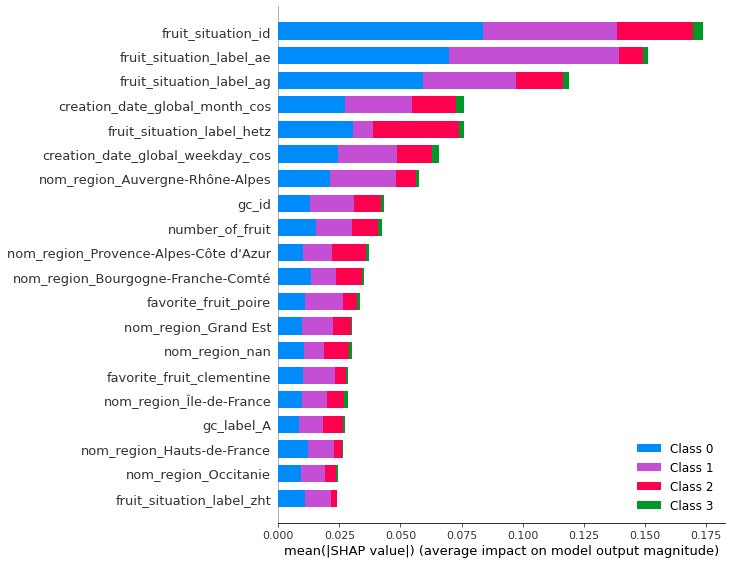

In [223]:
shap.summary_plot(shap_values, X_train_transformed_small, feature_names = f_names)

#### == Analyse == 
Les features les plus importantes toutes classes confondues sont : 
- fruit_situation_id
- fruit_situation_label_ae

On voit par exemple que la feature fruit_situation_label_hetz est très importante pour la classe 2 (comme vu dans la partie 3.5.1 du notebook 1)